In [1]:
%matplotlib inline

import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.layers import ConvLSTM2D
import datetime
from math import sqrt
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, Dense, GlobalAveragePooling1D, RNN, GRUCell, Dropout
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Bidirectional
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Flatten
import warnings

In [2]:
df = pd.read_csv('final_df_UE.csv', index_col = 'year', header = 0)

fr_co2 = df[(df['Sector'] == 'Transportation') & (df['Gas'] == 'CO2') & (df['Country'] == 'France')]
fr_co2= fr_co2.drop(['Country','Sector','Gas'], axis = 1)
fr_co2.sort_index( ascending = True, inplace = True)
fr_co2.drop(['Unit','Unnamed: 0'], axis = 1, inplace = True)



In [3]:
X_train = fr_co2.head(24)

X_test  = fr_co2.tail(6)

In [4]:
#prediction
raw_seq = X_train.values.tolist()
#forecast
raw_seq_f = fr_co2.values.tolist()

In [5]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)


## V - 1 - Vanilla LSTM <a class="anchor" id="V"></a>

### V - 1 - a Prediction<a class="anchor" id="V-pred"></a>

In [48]:
# choose a number of time steps
n_steps = 3

In [49]:
# split into samples
X, y = split_sequence(raw_seq, n_steps)

In [50]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

In [51]:
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [52]:
# fit model
model.fit(X, y, epochs=200, verbose=0)

In [53]:
Xinput = X_train.tail(7).values


In [54]:
for i in range (5):    
    x_input = array(Xinput[-3:])
    x_input = x_input.reshape((1, n_steps, n_features))
    yhat = model.predict(x_input, verbose=0)
    
    Xinput = np.concatenate((Xinput, yhat))

In [55]:
Prediction = pd.DataFrame(index = list(range(2014,2020)), data = Xinput[-6:])
Prediction = Prediction.rename({0: 'cons'}, axis=1)
total_pred = pd.concat(
    [fr_co2.head(25),Prediction])

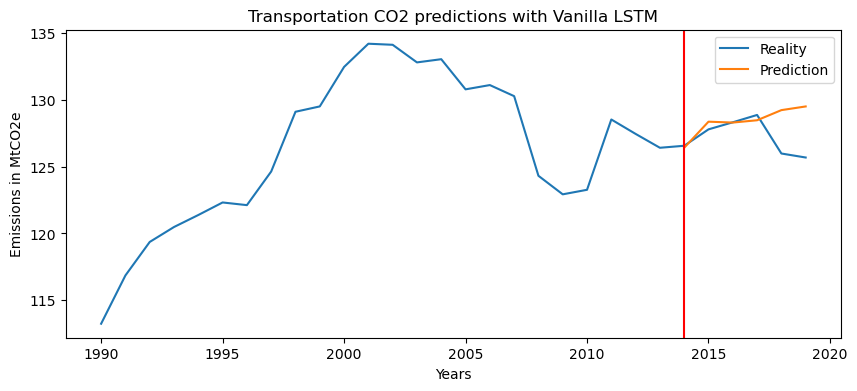

In [56]:
plt.figure(figsize = (10,4))
plt.plot(fr_co2, label='Reality')
plt.plot(total_pred.tail(6),label = 'Prediction')
plt.axvline(x=2014, color='red')
plt.xlabel('Years')
plt.ylabel('Emissions in MtCO2e')
plt.title('Transportation CO2 predictions with Vanilla LSTM')
plt.legend()
plt.show()

In [59]:
MAE_Va = mean_absolute_error(X_test,Prediction)
print('MAE VA :',MAE_Va)

MAE VA : 1.3704800415039078


## VII - 2 - Stacked LSTM  <a class="anchor" id="S"></a>

In [24]:
# define model
model_stacked = Sequential()
model_stacked.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model_stacked.add(LSTM(50, activation='relu'))
model_stacked.add(Dense(1))
model_stacked.compile(optimizer='adam', loss='mse')
# fit model
model_stacked.fit(X, y, epochs=200, verbose=0)


In [25]:
Xinput = X_train.tail(3).values

In [26]:
for i in range (5):    
    x_input = array(Xinput[-3:])
    x_input = x_input.reshape((1, n_steps, n_features))
    yhat = model_stacked.predict(x_input, verbose=0)
    
    Xinput = np.concatenate((Xinput, yhat))
    


In [27]:
Prediction = pd.DataFrame(index = list(range(2014,2020)), data = Xinput[-6:])
Prediction = Prediction.rename({0: 'cons'}, axis=1)
total_pred = pd.concat(
    [fr_co2.head(25),Prediction])

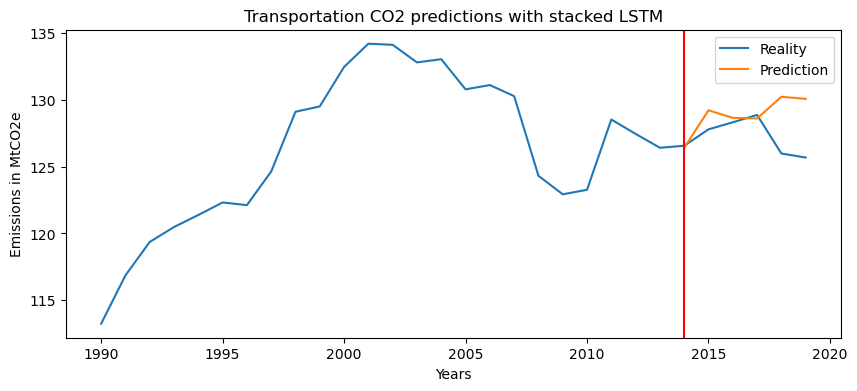

In [28]:
plt.figure(figsize = (10,4))

plt.plot(fr_co2, label='Reality')
plt.plot(total_pred.tail(6),label = 'Prediction')

plt.axvline(x=2014, color='red')

plt.xlabel('Years')
plt.ylabel('Emissions in MtCO2e')
plt.title('Transportation CO2 predictions with stacked LSTM')

plt.legend()
plt.show()

In [29]:
MAE_Stacked = mean_absolute_error(X_test,Prediction)
print('MAE Stacked :',MAE_Stacked)

MAE Stacked : 1.8043465169270807


## VII - 3 - Bidirectional LSTM  <a class="anchor" id="B"></a>

In [30]:
Xinput = X_train.tail(3).values


In [31]:
# define model
model_Bi = Sequential()
model_Bi.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(n_steps, n_features)))
model_Bi.add(Dense(1))
model_Bi.compile(optimizer='adam', loss='mse')

# fit model
model_Bi.fit(X, y, epochs=200, verbose=0)

In [32]:
for i in range (5):    
    x_input = array(Xinput[-3:])
    x_input = x_input.reshape((1, n_steps, n_features))
    yhat = model_Bi.predict(x_input, verbose=0)
    
    Xinput = np.concatenate((Xinput, yhat))   


In [33]:
Prediction = pd.DataFrame(index = list(range(2014,2020)), data = Xinput[-6:])
Prediction = Prediction.rename({0: 'cons'}, axis=1)
total_pred = pd.concat(
    [fr_co2.head(25),Prediction])

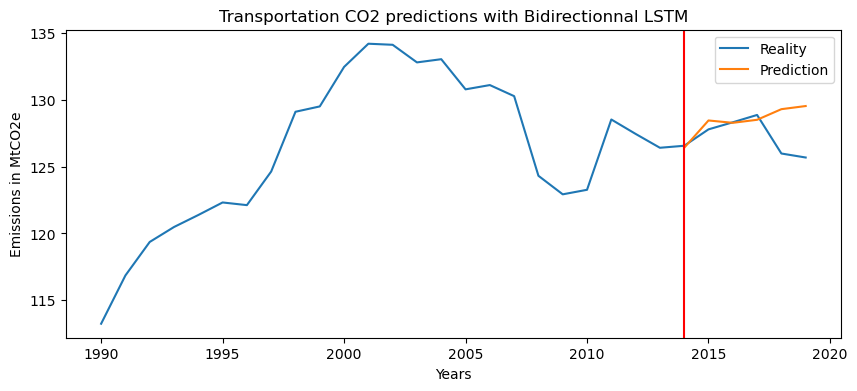

In [34]:
plt.figure(figsize = (10,4))

plt.plot(fr_co2, label='Reality')
plt.plot(total_pred.tail(6),label = 'Prediction')

plt.axvline(x=2014, color='red')

plt.xlabel('Years')
plt.ylabel('Emissions in MtCO2e')
plt.title('Transportation CO2 predictions with Bidirectionnal LSTM')

plt.legend()
plt.show()

In [35]:
MAE_Bi = mean_absolute_error(X_test,Prediction)
print('MAE Bi :',MAE_Bi)

MAE Bi : 1.4000541178385433


## VII - 4 - CNN LSTM  <a class="anchor" id="CNN"></a>

In [36]:


# choose a number of time steps
n_steps = 4
# split into samples
X, y = split_sequence(raw_seq, n_steps)
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
n_features = 1
n_seq = 2
n_steps = 2
X = X.reshape((X.shape[0], n_seq, n_steps, n_features))
# define model

model_CNN = Sequential()
model_CNN.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, n_steps, n_features)))
model_CNN.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model_CNN.add(TimeDistributed(Flatten()))
model_CNN.add(LSTM(50, activation='relu'))
model_CNN.add(Dense(1))
model_CNN.compile(optimizer='adam', loss='mse')
# fit model

model_CNN.fit(X, y, epochs=500, verbose=0)


In [37]:
for i in range (5):    
    x_input = array(Xinput[-4:])
    x_input = x_input.reshape((1, n_seq, n_steps, n_features))
    yhat = model_CNN.predict(x_input, verbose=0)
    
    Xinput = np.concatenate((Xinput, yhat))   


In [38]:
Prediction = pd.DataFrame(index = list(range(2014,2020)), data = Xinput[-6:])
Prediction = Prediction.rename({0: 'cons'}, axis=1)
total_pred = pd.concat(
    [fr_co2.head(25),Prediction])

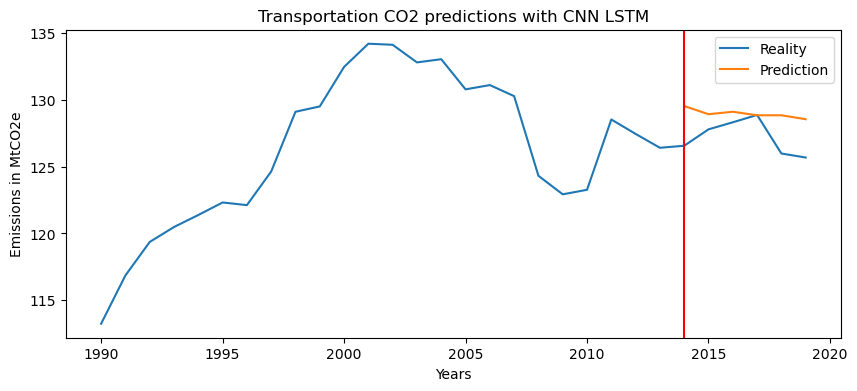

In [39]:
plt.figure(figsize = (10,4))

plt.plot(fr_co2, label='Reality')
plt.plot(total_pred.tail(6),label = 'Prediction')

plt.axvline(x=2014, color='red')

plt.xlabel('Years')
plt.ylabel('Emissions in MtCO2e')
plt.title('Transportation CO2 predictions with CNN LSTM')

plt.legend()
plt.show()

In [40]:
MAE_CNN = mean_absolute_error(X_test,Prediction)
print('MAE CNN :',MAE_CNN)

MAE CNN : 1.777936299641927


## VII - 5 - ConvLSTM  <a class="anchor" id="Conv"></a>

In [41]:


# choose a number of time steps
n_steps = 4
# split into samples
X, y = split_sequence(raw_seq, n_steps)
# reshape from [samples, timesteps] into [samples, timesteps, rows, columns, features]
n_features = 1
n_seq = 2
n_steps = 2
X = X.reshape((X.shape[0], n_seq, 1, n_steps, n_features))

In [42]:
# define model
model_Conv = Sequential()
model_Conv.add(ConvLSTM2D(filters=64, kernel_size=(1,2), activation='relu', input_shape=(n_seq, 1, n_steps, n_features)))
model_Conv.add(Flatten())
model_Conv.add(Dense(1))
model_Conv.compile(optimizer='adam', loss='mse')
# fit model
model_Conv.fit(X, y, epochs=500, verbose=0)

In [43]:
for i in range (5):    
    x_input = array(Xinput[-4:])
    x_input = x_input.reshape((1, n_seq, 1, n_steps, n_features))
    yhat = model_Conv.predict(x_input, verbose=0)
    
    Xinput = np.concatenate((Xinput, yhat))   


In [44]:
Prediction = pd.DataFrame(index = list(range(2014,2020)), data = Xinput[-6:])
Prediction = Prediction.rename({0: 'cons'}, axis=1)
total_pred = pd.concat(
    [fr_co2.head(25),Prediction])

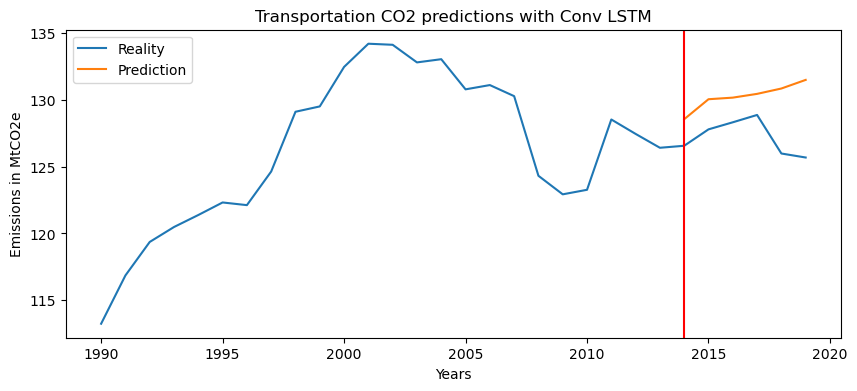

In [45]:
plt.figure(figsize = (10,4))

plt.plot(fr_co2, label='Reality')
plt.plot(total_pred.tail(6),label = 'Prediction')

plt.axvline(x=2014, color='red')

plt.xlabel('Years')
plt.ylabel('Emissions in MtCO2e')
plt.title('Transportation CO2 predictions with Conv LSTM')

plt.legend()
plt.show()

In [46]:
MAE_Conv = mean_absolute_error(X_test,Prediction)
print('MAE Conv :',MAE_Conv)

MAE Conv : 3.0617081705729183


In [60]:
MAE = pd.DataFrame( index = ['Vanilla','Stacked','Bidirectionnal','CNN','Conv'], data = [MAE_Va, MAE_Stacked, MAE_Bi, MAE_CNN, MAE_Conv])
MAE.rename(columns={0: 'MAE'}, inplace=True)
MAE

,MAE
Vanilla,1.370480
Stacked,1.804347
Bidirectionnal,1.400054
CNN,1.777936
Conv,3.061708
